In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

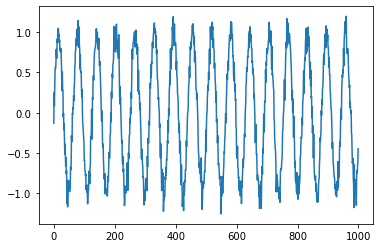

In [56]:
# make the original data
N = 1000
series = np.sin(0.1*np.arange(N)) + np.random.randn(N)*0.1

# plot it
plt.plot(series)
plt.show()
#print(series)

In [57]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
X = np.array(X).reshape(-1,T,1)
Y = np.array(Y).reshape(-1,1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)   # X 가 3차원이여야 함 --> 바로 input size = 1 (Feature 수)이 있어야 함

X.shape (990, 10, 1) Y.shape (990, 1)


In [58]:
X.size

9900

In [59]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [60]:
## Define simple RNN
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        # note: batch_first = True
        # applies the convention that our data will be of shape:
        # (num_samples, sequence_length, num_features)
        # rather than:
        # (sequence_length, num_samples, num_features)
        self.rnn = nn.RNN(
            input_size = self.D,
            hidden_size = self.M,
            num_layers = self.L,
            nonlinearity = 'relu',
            batch_first = True)
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)    # X.size(0) --> X tensor일때 int로 전환하는 것이 "(0)"이다
        # h0 = torch.Size([1, 495, 5])
        
        # In order to match of nn.RNN's order --> input_size, hidden_size, num_layers
        #h0 = torch.zeros(X.size(0), self.M, self.L).to(device)
        
        # get RNN unit output
        # out is of size (N, T, M)
        # 2nd return value is hidden states at each hidden layer
        # we don't need those now
        out, _ = self.rnn(X, h0)
        
        # we only want h(T) at the final time step
        # N x M -> N x K
        out = self.fc(out[:,-1,:])
        return out
    

In [61]:
# Instantiate the model
model = SimpleRNN(n_inputs = 1, n_hidden=5, n_rnnlayers = 1, n_outputs = 1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [62]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

In [63]:
# Make inputs and targets
X_train = torch.from_numpy(X[:N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:N//2].astype(np.float32))
X_test = torch.from_numpy(X[N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[N//2:].astype(np.float32))

In [64]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [65]:
X_train.shape

torch.Size([495, 10, 1])

In [66]:
# Training
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs = 200):
    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Save losses
        train_losses[it] = loss.item()
        
        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        if (it+1) % 5 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss:  {test_loss.item():.4f}')
    
    return train_losses, test_losses

In [67]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

Epoch 5/200, Train Loss: 0.1472, Test Loss:  0.0298
Epoch 10/200, Train Loss: 0.0390, Test Loss:  0.0350
Epoch 15/200, Train Loss: 0.0250, Test Loss:  0.0289
Epoch 20/200, Train Loss: 0.0250, Test Loss:  0.0264
Epoch 25/200, Train Loss: 0.0246, Test Loss:  0.0243
Epoch 30/200, Train Loss: 0.0242, Test Loss:  0.0241
Epoch 35/200, Train Loss: 0.0239, Test Loss:  0.0251
Epoch 40/200, Train Loss: 0.0235, Test Loss:  0.0250
Epoch 45/200, Train Loss: 0.0237, Test Loss:  0.0247
Epoch 50/200, Train Loss: 0.0235, Test Loss:  0.0238
Epoch 55/200, Train Loss: 0.0230, Test Loss:  0.0234
Epoch 60/200, Train Loss: 0.0227, Test Loss:  0.0234
Epoch 65/200, Train Loss: 0.0227, Test Loss:  0.0233
Epoch 70/200, Train Loss: 0.0225, Test Loss:  0.0232
Epoch 75/200, Train Loss: 0.0224, Test Loss:  0.0231
Epoch 80/200, Train Loss: 0.0223, Test Loss:  0.0230
Epoch 85/200, Train Loss: 0.0222, Test Loss:  0.0229
Epoch 90/200, Train Loss: 0.0222, Test Loss:  0.0228
Epoch 95/200, Train Loss: 0.0221, Test Loss:  0

In [68]:
torch.zeros(1, X_train.size(0), 5).shape

torch.Size([1, 495, 5])

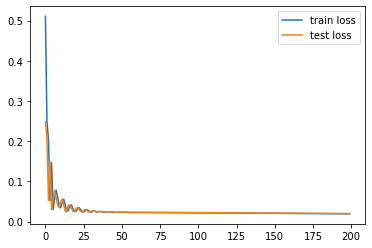

In [69]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show()

In [70]:
# "Wrong" forecast using true targets

validation_target = Y[N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].reshape(1,T,1)
    p = model(input_)[0,0].item()     # 각 row에 따라 나누어 prediction 하기 때문에 [0,0] item으로 값을 받음 -> scalar
    i += 1
    
    # update the predictions list
    validation_predictions.append(p)

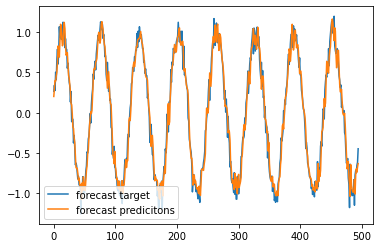

In [71]:
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast predicitons')
plt.legend()
plt.show()

In [72]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1,T,1)
    p = model(input_)
    
    # update the predictions list
    validation_predictions.append(p[0,0].item())
    
    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))   # last_x에서 9개만 선택 후 p[0]의 prediction 값 1개를 row로 추가하여 last_x에 다시 저장
    # cat은 row bind 혹은 col bind와 같은 역할을 함 : torch.cat((x,x,x), 0) -> row, torch.cat((x,x,x),1) -> col

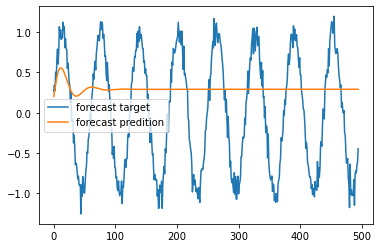

In [73]:
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast predition')
plt.legend()
plt.show()